# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [1]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
import inspect
from pathlib import Path
warnings.filterwarnings('ignore')

import analysis.data_loading as dl
import analysis.basic_metrics as basic
import analysis.creativity_metrics as creativity
import analysis.cohesion_metrics as cohesion

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

Created plots directory: plots


# Set calculation parameters

In [141]:
CAMPAIGN_NAME = [
    '10391-guardians-of-gridori',
    'llm_campaign_10391-guardians-of-gridori_claude-3-5-sonnet-latest_no_players_20250812_145320',
    'llm_campaign_10391-guardians-of-gridori_claude-3-5-sonnet-latest_players_20250812_205654',
    'llm_campaign_10391-guardians-of-gridori_gpt-4o_no_players_20250812_124127',
    'llm_campaign_10391-guardians-of-gridori_gpt-4o_players_20250812_142021'
]
source = CAMPAIGN_NAME
#source = 'human'
max_campaigns = 969 
messages_per_session = 5
force_refresh = False
scene_length = 175

# Calculate game log analyses

In [142]:
dfs = dl.load_campaigns(source=source, max_campaigns = max_campaigns, messages_per_session=messages_per_session)

basic_metrics = basic.analyze_basic_metrics(dfs, force_refresh=force_refresh)

creativity_metrics = creativity.analyze_creativity(dfs,
                                                   force_refresh=False)

dsi_metrics = creativity.analyze_dsi(dfs,
                                     force_refresh=force_refresh,
                                     target_words=scene_length)

cohesion_metrics = cohesion.analyze_cohesion(dfs, messages_per_session=5, force_refresh=False)


📁 Loaded 5 cached basic metrics results
📁 Loaded 5 cached creativity results
📁 Loaded 5 cached DSI results
📁 Loaded 5 cached cohesion results


# Plot

In [143]:
def plot_histogram(data,
                   colors=None,
                   edgecolor='none',
                   alpha=0.5,
                   colormap='viridis',
                   xlabel=None,
                   bins=None,
                   log_bins=False,
                   log_y=False,
                   figsize=(4,4),
                   ylabel="Counts",
                   labels=None):
    """
    Plot histogram(s) with colors evenly spaced across a colormap.
    
    Parameters:
    data: Single array/list OR list of arrays/lists to plot as histograms
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    """
    plt.figure(figsize=figsize)

    # Auto-detect if data is a single array or list of arrays
    try:
        if isinstance(data[0], (list, np.ndarray)):
            data_list = data  # Already a list of arrays
        else:
            data_list = [data]  # Single array, wrap it in a list
    except:
        data_list = [data]

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    n_plots = len(clean_data_list)

    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_plots == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_plots - 1)) for i in range(n_plots)]

    # Calculate common bins across all datasets (now NaN-free)
    all_data = np.concatenate(clean_data_list)

    if len(all_data) == 0:
        raise ValueError("All data contains only NaN values")

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50  # Default number of log bins

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50  # Default number of bins

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Plot all histograms with the same bins (NaN-free data)
    for i, dataset in enumerate(clean_data_list):
        if labels is not None:
            label = labels[i]
        else:
            label = None
        plt.hist(dataset,
                 bins=common_bins,
                 color=colors[i],
                 edgecolor=edgecolor,
                 alpha=alpha,
                 label=label)

    # Set axis scales
    if log_bins:
        plt.xscale('log')

    if log_y:
        plt.yscale('log')

    sns.despine()
    plt.ylabel(ylabel)

    if xlabel is not None:
        plt.xlabel(xlabel)

    # Style axes
    ax = plt.gca()
    ax.tick_params(colors='#4a4a4a', width=0.5)
    ax.spines['left'].set_color('#4a4a4a')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#4a4a4a')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.label.set_color('#4a4a4a')
    ax.yaxis.label.set_color('#4a4a4a')

In [153]:
names = list(dfs.keys())

time_invervals_campaigns = []
post_len_campaigns = []
sbert_post_distances = []
sbert_session_creativity = []
cohesion_session_scores = []
dsi_scenes = []
for name in names:
    print(name)

    # get time interval distributions
    time_invervals_campaigns.append(basic_metrics[name]['time_intervals_overall']['overall']['intervals_data'])

    # get word count distritbutions
    post_len_campaigns.append(basic_metrics[name]['post_lengths_overall']['overall']['word_counts_data'])

    # get semantic distances (SBERT) distribtuions
    sbert_post_distances.append(np.array(creativity_metrics[name]['semantic_distances']))

    # sbert sessions
    sbert_session_creativity.append(np.array(creativity_metrics[name]['session_novelty'][['mean_distance']]))

    # get dsi distributions
    dsi_scenes.append(dsi_metrics[name]['scene_dsi_scores'])

    # get cohesion dists
    if cohesion_metrics[name] is None:
        cohesion_session_scores.append(np.array(np.nan))
    else:
        cohesion_session_scores.append(np.array(cohesion_metrics[name]['session_cohesion_scores']))

    # plot time interval distributions per player
    player_names = basic_metrics[name]['time_intervals_by_player'].keys()
    time_intervals_player_list = []
    for player_name in player_names:
        time_intervals_player_list.append(
            basic_metrics[name]['time_intervals_by_player'][player_name]
            ['intervals_data'])
    #plot_histogram(time_intervals_player_list, bins=50, xlabel='time invervals by player', colormap='magma')

    # plot word count distributions per player
    post_len_player_list = []
    for player_name in player_names:
        post_len_player_list.append(basic_metrics[name]['post_lengths_by_player'][player_name]['word_counts_data'])
    #plot_histogram(post_len_player_list, bins=50, xlabel='post lengths by player', colormap='magma')


#plot_histogram(time_invervals_campaigns, bins=50, xlabel='time intervals by campaign')
#plot_histogram(post_len_campaigns, bins=50, xlabel='post len by campaign')
#plot_histogram(sentence_session_distances, bins=30, xlabel='sbert by campaign')
#plot_histogram(dsi_scenes, bins=50, xlabel='dsi by campaign')

10391-guardians-of-gridori
llm_campaign_10391-guardians-of-gridori_claude-3-5-sonnet-latest_no_players_20250812_145320
llm_campaign_10391-guardians-of-gridori_claude-3-5-sonnet-latest_players_20250812_205654
llm_campaign_10391-guardians-of-gridori_gpt-4o_no_players_20250812_124127
llm_campaign_10391-guardians-of-gridori_gpt-4o_players_20250812_142021


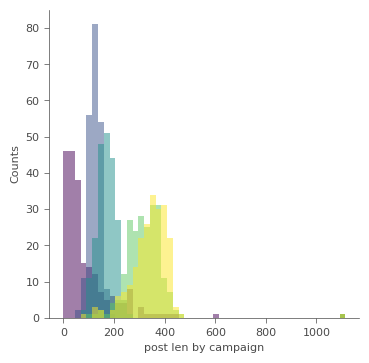

In [145]:
plot_histogram(post_len_campaigns,
               bins=50,
               xlabel='post len by campaign',
               labels=list(dfs.keys()))
#plt.legend()

In [ ]:
def plot_comparison_histograms(data, colors=None, edgecolor='none', alpha=0.5, colormap='viridis', 
                              xlabel=None, bins=None, log_bins=False, log_y=False, labels=None,
                              figsize=None):
    """
    Plot comparison histograms with the first dataset appearing in every subplot,
    and each subsequent dataset compared against it in separate vertical subplots.
    
    Parameters:
    data: List of arrays/lists (must have at least 2 datasets)
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    labels (list): Labels for each dataset (default: None)
    figsize (tuple): Figure size (width, height). If None, auto-calculated
    """
    
    # Validate input
    if not isinstance(data, list) or len(data) < 2:
        raise ValueError("data must be a list with at least 2 datasets")
    
    # Auto-detect if data contains arrays or single values
    data_list = []
    for dataset in data:
        try:
            if isinstance(dataset[0], (list, np.ndarray)):
                data_list.append(dataset)
            else:
                data_list.append(dataset)
        except:
            data_list.append(dataset)
    
    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)
    
    if any(len(dataset) == 0 for dataset in clean_data_list):
        raise ValueError("One or more datasets contain only NaN values")
    
    n_datasets = len(clean_data_list)
    n_subplots = n_datasets - 1  # Number of comparison subplots
    
    # Set up figure size
    if figsize is None:
        figsize = (8, 3 * n_subplots)  # 3 inches height per subplot
    
    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, sharex=True)
    
    # Handle case where there's only one comparison (single axis)
    if n_subplots == 1:
        axes = [axes]
    
    # Set up colors
    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_datasets == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_datasets - 1)) for i in range(n_datasets)]
    
    # Calculate common bins across all datasets
    all_data = np.concatenate(clean_data_list)
    
    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")
        
        min_val = np.min(positive_data)
        max_val = np.max(positive_data)
        
        if bins is None:
            bins = 50
        
        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50
        
        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)
    
    # Reference dataset (first one)
    reference_data = clean_data_list[0]
    reference_color = colors[0]
    reference_label = labels[0] if labels is not None else "Reference"
    
    # Plot each comparison
    for i in range(n_subplots):
        ax = axes[i]
        
        # Current comparison dataset (i+1 because we skip the reference)
        comparison_data = clean_data_list[i + 1]
        comparison_color = colors[i + 1]
        comparison_label = labels[i + 1] if labels is not None else f"Dataset {i + 1}"
        
        # Plot reference histogram (same in every subplot)
        ax.hist(reference_data, bins=common_bins, color=reference_color, 
                edgecolor=edgecolor, alpha=alpha, label=reference_label)
        
        # Plot comparison histogram
        ax.hist(comparison_data, bins=common_bins, color=comparison_color,
                edgecolor=edgecolor, alpha=alpha, label=comparison_label)
        
        # Set axis scales
        if log_bins:
            ax.set_xscale('log')
        
        if log_y:
            ax.set_yscale('log')
        
        # Style the subplot
        sns.despine(ax=ax)
        
        # Only add ylabel to the middle subplot
        if i == n_subplots // 2:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")
        
        # Don't add legend here - can be added outside function if needed
        
        # Style axes
        ax.tick_params(colors='#4a4a4a', width=0.5)
        ax.spines['left'].set_color('#4a4a4a')
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_color('#4a4a4a')
        ax.spines['bottom'].set_linewidth(0.5)
        ax.xaxis.label.set_color('#4a4a4a')
        ax.yaxis.label.set_color('#4a4a4a')
    
    # Only add xlabel to the bottom subplot
    if xlabel is not None:
        axes[-1].set_xlabel(xlabel)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Set same y-limits for all subplots
    # Find the maximum y-limit across all subplots
    max_ylim = 0
    for ax in axes:
        current_ylim = ax.get_ylim()[1]
        max_ylim = max(max_ylim, current_ylim)
    
    # Apply the same y-limit to all subplots
    for ax in axes:
        ax.set_ylim(0, max_ylim)
    
    return fig, axes

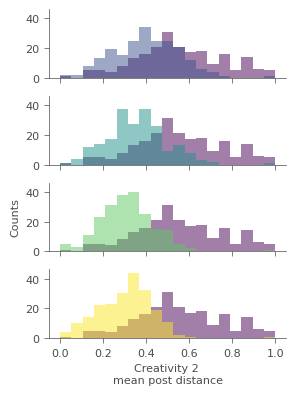

In [165]:
plot_comparison_histograms(
    sbert_post_distances,  #post_len_campaigns,
    bins=20,
    xlabel='Creativity 2 \nmean post distance',
    figsize=(3, 4))

plt.tight_layout()
plt.savefig('single_creativity1.pdf', transparent=True)

(<Figure size 300x400 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: ylabel='Counts'>,
        <Axes: xlabel='Creativity 3 \ndivergent semantic integration'>],
       dtype=object))

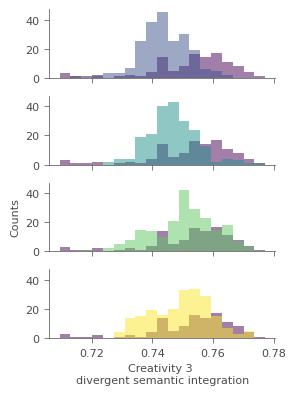

In [167]:
plot_comparison_histograms(dsi_scenes,#post_len_campaigns,
                           bins=20,
                           xlabel='Creativity 3 \ndivergent semantic integration',
                           figsize=(3,4))

(<Figure size 200x400 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: ylabel='Counts'>,
        <Axes: xlabel='Cohesion \nmean Jaccard similarity'>], dtype=object))

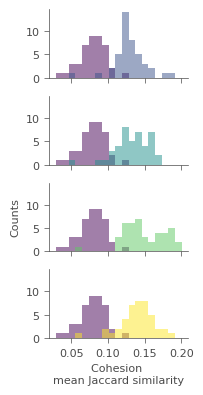

In [169]:
plot_comparison_histograms(cohesion_session_scores,#post_len_campaigns,
                           bins=20,
                           xlabel='Cohesion \nmean Jaccard similarity',
                           figsize=(2,4))

(<Figure size 200x400 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: ylabel='Counts'>,
        <Axes: xlabel='Creativity 1 \nmean session distance'>],
       dtype=object))

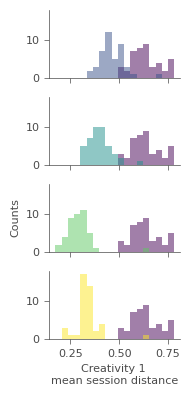

In [170]:
plot_comparison_histograms(sbert_session_creativity,    #post_len_campaigns,
                           bins=20,
                           xlabel='Creativity 1 \nmean session distance',
                           figsize=(2,4))

(<Figure size 200x400 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: ylabel='Counts'>,
        <Axes: xlabel='Post length'>], dtype=object))

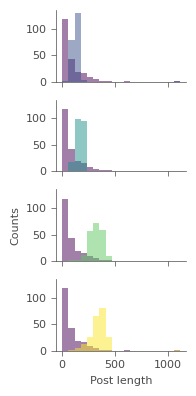

In [171]:
plot_comparison_histograms(post_len_campaigns,    #post_len_campaigns,
                           bins=20,
                           xlabel='Post length',
                           figsize=(2,4))

In [152]:
mean_sbert_session_creat = np.zeros(len(sbert_session_creativity))
mean_cohesion_session = np.zeros(len(cohesion_session_scores))
mean_sbert_post_distances = np.zeros(len(sbert_post_distances))

for i in range(len(sbert_session_creativity)):
    mean_sbert_session_creat[i] = np.mean(sbert_session_creativity[i])
    mean_cohesion_session[i] = np.mean(cohesion_session_scores[i])
    mean_sbert_post_distances[i] = np.nanmean(sbert_post_distances[i])

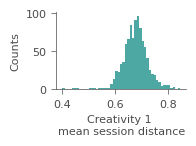

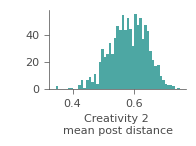

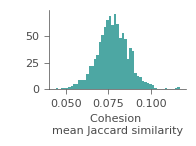

In [140]:
plt.rcParams.update({'font.size': 8})
plot_histogram(mean_sbert_session_creat,
               figsize=(2, 1.5),
               bins=50,
               alpha=0.8,
               xlabel='Creativity 1 \nmean session distance',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('creativity1.pdf', transparent=True)

plot_histogram(mean_sbert_post_distances,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=50,
               alpha=0.8,
               xlabel='Creativity 2 \nmean post distance',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('creativity2.pdf', transparent=True)

plot_histogram(mean_cohesion_session,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=50,
               alpha=0.8,
               xlabel='Cohesion \nmean Jaccard similarity',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('cohesion.pdf', transparent=True)

In [127]:
time_invervals_agg = np.concatenate(time_invervals_campaigns)
post_lengths_agg = np.concatenate(post_len_campaigns)

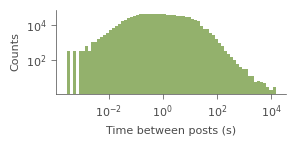

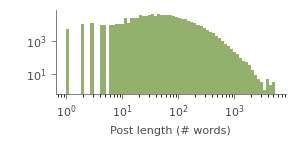

In [135]:
plot_histogram(time_invervals_agg,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (s)',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('time_intervals.pdf', transparent=True)

plot_histogram(post_lengths_agg,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('post_lens.pdf', transparent=True)

In [ ]:
# save 5 plots
# make the simple metrics in 1 color and more complex in another? teal and chartreuse? 
# fix the x axis labels
# chartreuse (197,170,46)